# Predicting Bubblepoint Pressure for Middle East Crude Oils using Random Forest Regression
Connor McAnuff - November 2019

For this project, I've taken a quick look at predicting bubblepoint pressure of Middle East crude oils using Pressure-Volume-Temperature (PVT) properties known to be correllated with bubblepoint pressure. This project is not intended to be a comprehensive assessment or state-of-the-art model - it is an exercise in implementing a random forest regression on scientific oil and gas data.

Using a dataset of 160 oil/gas mixture samples, the tuned random forest model predicts on out-of-sample observations (20% of original dataset) the bubblepoint pressure with a mean absolute percentage error of 7.56%. The model was then used to predict the bubblepoint pressure of an additional 5 samples from a different source with a mean absolute percentage error of 7.59%, indicating that the model has generalized well (many more samples would be needed to confirm this conclusion). The results have been compared to those of Al-Mahroun (1988).

## Contents:
1) Project Background

2) Data Importing

3) Data Cleaning

4) Data Exploration

5) Al-Marhoun Predictions

6) Random Forest Regression


## References:
[1] https://pdfs.semanticscholar.org/5c8a/3bb589dac09a96c9cf623795a74713c68f6b.pdf

[2] https://www.researchgate.net/publication/240779975_PVT_Correlations_for_Middle_East_Crude_Oils

[3] Reservoir Engineering Handbook, 4th Ed.


## 1) Project Background

### Why predict bubblepoint pressure?

Bubblepoint pressure is required in the oil and gas industry for material balance calculations, analysis of well performance, reservoir simulation, and production engineering calculations. Furthermore, bubblepoint pressure is directly or indirectly involved in every oil property calculation. Thus, knowledge of bubblepoint pressure is crucial in the development of an oil field [1]. 

Estimating bubblepoint pressure has been the subject of many studies. The estimation methods make use of correlations between data typically available in the field (e.g. gas-oil ratio, gas specific gravity, oil gravity, and reservoir temperature) and bubblepoint pressure [1].

There have been many studies in which machine learning has been used to estimate bubblepoint pressure:
- [Artificial Intelligence Techniques for Predicting the Reservoir Fluid Properties of Crude Oil Systems](https://pdfs.semanticscholar.org/fa27/e9dcf8096164f529a5290df6cda8fa0b67c3.pdf)
- [A comparative analysis of bubble point pressure prediction using advanced machine learning algorithms and classical correlations](https://www.researchgate.net/publication/336662731_A_comparative_analysis_of_bubble_point_pressure_prediction_using_advanced_machine_learning_algorithms_and_classical_correlations)
- [Prediction of Bubble Point Pressure Using Artificial Intelligence AI Techniques](https://www.researchgate.net/publication/310622176_Prediction_of_Bubble_Point_Pressure_Using_Artificial_Intelligence_AI_Techniques)

Let's give it a go ourselves!

### Dataset

The largest dataset I could find online for free was from a study by Muhammad All Al-Marhoun in May 1988 [2]. Certainly, there are more recent and comprehensive datasets existing, but for this project Al-Marhoun's dataset will serve our purposes fine.

The dataset includes 160 observations of experimentally determined bubblepoint pressures of 69 different Middle East oil/gas mixtures. Given alongside bubblepoint pressure for each observation is Gas-Oil Ratio (GOR), Average Gas Relative Density (Yg), API Gravity at 60 deg. F (Yapi), and Temperature in Farenheit (Tf). 

## 1) Data Importing

In [7]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [214]:
%watermark -a "Connor McAnuff" -d -t -v -p numpy,pandas

Connor McAnuff 2019-11-08 16:15:01 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.4
pandas 0.24.2


In [9]:
import numpy as np 
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

from tqdm import tqdm_notebook as tqdm

PROJ_ROOT = os.path.join(os.pardir)

In [181]:
# Set paths to data
data_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'bpp_data.csv'))

ahmed_data_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'bpp_data_ahmed.csv'))

output_model_path = str(os.path.join(PROJ_ROOT,
                            'models\\'))

In [183]:
df = pd.read_csv(data_path, index_col='sample')

In [184]:
df.head()

,bp_p,gor,yg,y_api,Tf
sample,,,,,
1,"3,573","1,507",0.951.,39.3.,225
2,"3,571",898,0.802.,32.7.,175
3,"3,426",898,0.802.,32.7.,150
4,"3,405","1,579",0.930.,42.8.,235
5,"3,354",825,0.779.,34.2.,185


- bp_p: bubblepoint pressure (psia)
- gor: gas-oil ratio (scf/STB)
- yg: Average gas relative density (air = 1)
- y_api: API gravity at 60 deg. F (deg. API)
- Tf: Temperature (deg. F)

## 2) Data Cleaning

The data was sourced from a scanned PDF of the original paper by Al-Mahroun. The scanned pdf was automatically converted to text using a free online converter. The text was saved as a csv file and imported as a DataFrame above. 4 of the columns were imported as strings and include some characters we don't want - we can clean up the data using .str methods and convert to our datatype of choice.

Additionally, the y_api and Tf columns will be converted to new units to match those in Al-Marhoun's equation. 

In [185]:
# Remove commas from bp_p and gor and convert to integers
df['bp_p'] = df['bp_p'].str.replace(',', '').astype(int)
df['gor'] = df['gor'].str.replace(',', '').astype(int)

In [188]:
# Check to make sure every observation in yg ends in a decimal and remove, then convert to float
for i, row in enumerate(df['yg']):
    assert df['yg'].iloc[i][-1] == '.'
        
df['yg'] = df['yg'].str.rstrip('.').astype('float')

In [189]:
# Check to make sure every observation in y_api ends in a decimal and remove, then convert to float
for i, row in enumerate(df['y_api']):
    assert df['y_api'].iloc[i][-1] == '.'
        
df['y_api'] = df['y_api'].str.rstrip('.').astype('float')

In [58]:
# Convert y_api to y_0 (oil relative density (water = 1)) - to be used in Al-Marhoun's equation
df['y_api'] = 141.5 / (df['y_api'] + 131.5)

# Convert Tf to T (Rankin scale) - to be used in Al-Marhoun's equation
df['Tf'] = df['Tf'] + 459.67

# Rename columns
df.columns = ['bp_p', 'gor', 'yg', 'y_0', 'T']

In [59]:
df.head()

,bp_p,gor,yg,y_0,T
sample,,,,,
1,3573,1507,0.95,0.83,684.67
2,3571,898,0.80,0.86,634.67
3,3426,898,0.80,0.86,609.67
4,3405,1579,0.93,0.81,694.67
5,3354,825,0.78,0.85,644.67


- bp_p: bubblepoint pressure (psia)
- gor: gas-oil ratio (scf/STB)
- yg: Average gas relative density (air = 1)
- y_0: oil relative density (water = 1)
- T: Temperature (deg. Rankine)

In [18]:
pd.options.display.float_format = "{:.2f}".format
df.describe()

,bp_p,gor,yg,y_0,T
count,160.00,160.00,160.00,160.00,160.00
mean,1731.12,557.54,0.97,0.86,604.41
std,1084.23,403.15,0.17,0.03,39.26
min,130.00,26.00,0.75,0.80,533.67
25%,596.75,194.25,0.80,0.84,559.67
50%,1868.50,560.00,0.93,0.86,609.67
75%,2660.75,782.00,1.06,0.88,634.67
max,3573.00,1602.00,1.37,0.94,699.67


## 3) Data Exploration 

In [19]:
# Function for plotting a histogram given a pandas series
def plot_hist(series, bins):
    fig, ax = plt.subplots(figsize=(6,6))
    plt.hist(series, bins=bins)
    plt.xlabel(series.name)
    plt.ylabel('Frequency')
    plt.show()

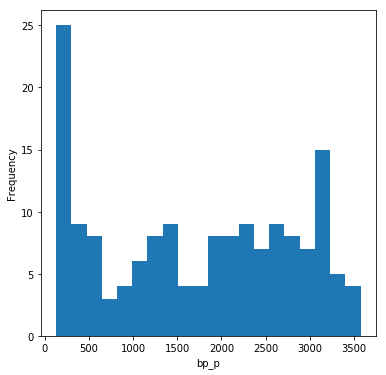

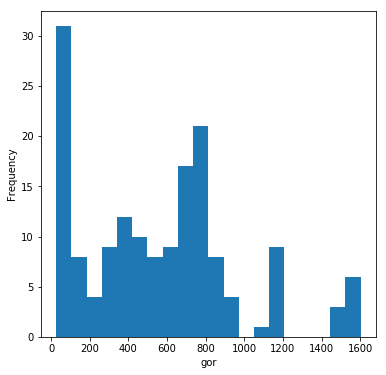

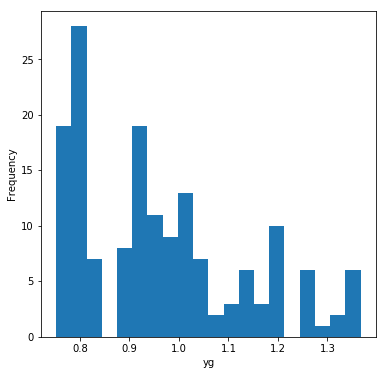

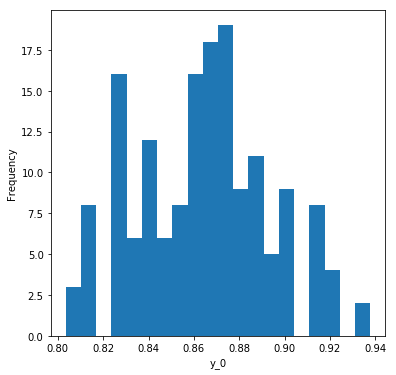

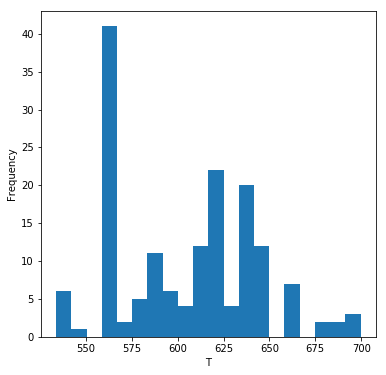

In [20]:
# Plot the distributions of each df column
for series in list(df):
    plot_hist(series=df[series], bins=20)

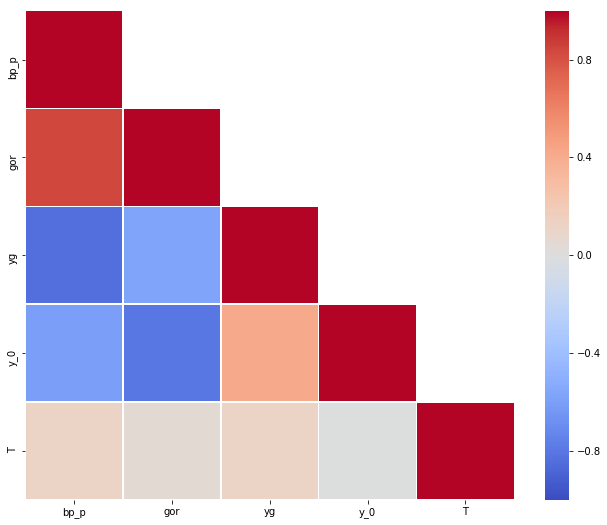

In [21]:
# Compute correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, False)

# Set column labels
column_labels = list(df)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, xticklabels=column_labels, yticklabels=column_labels)

plt.show()

Each of the target variables are correlated with bubblepoint pressure. Temperature has the weakest correlation. The features display multicollinearity. 

## 4) Al-Marhoun Predictions

Al-Marhoun produced the following relationship using nonlinear multiple regression analysis. We can reproduce his estimates of bubblepoint pressure using this formula:

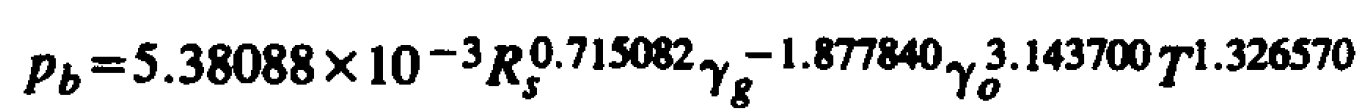

In [22]:
# Calculate Al-Mahroun predictions (also given in his paper) using the above equation
AM_pred = 5.38088 / 1000 *(df['gor'] ** 0.715082) * (df['yg'] ** -1.877840) * (df['y_0'] ** 3.143700) * ((df['T']) ** 1.326570)

### Model Evaluation
Al-Mahroun evaulated his model using the following metrics:
- Average relative error (%)
- Average absolute relative error (%)
- Minimum absolute relative error (%)
- Maximum absolute relative error (%)
- Correlation Coefficient

An important caveat is that these metrics were not calculated on out-of-sample data. Thus, the formula may be overfit to the specific dataset used. For evaluating our random forest model, the metrics will be calculated using a datatest set, previously unseen by the model, for a more accurate representation of how the model will perform when presented with new data.

In [23]:
from scipy.stats import pearsonr

In [190]:
# Functions to calculate model evaluation metrics

def mean_percentage_error(y_true, y_pred):
    return np.mean((y_true - y_pred) / y_true) * 100

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def min_absolute_percentage_error(y_true, y_pred):
    return np.min(np.abs((y_true - y_pred) / y_true)) * 100

def max_absolute_percentage_error(y_true, y_pred):
    return np.max(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
print('Al-Mahroun Model Evaluation Statistics:')
print('Mean percentage error: {}'.format(round(mean_percentage_error(df['bp_p'],AM_pred), 2)))
print('Mean absolute percentage error: {}'.format(round(mean_absolute_percentage_error(df['bp_p'],AM_pred), 2)))
print('Min absolute percentage error: {}'.format(round(min_absolute_percentage_error(df['bp_p'],AM_pred), 2)))
print('Max absolute percentage error: {}'.format(round(max_absolute_percentage_error(df['bp_p'],AM_pred), 2)))
print('Correlation coefficient: {}'.format(round(pearsonr(df['bp_p'],AM_pred)[0], 3)))

Al-Mahroun Model Evaluation Statistics:
Mean percentage error: -0.19
Mean absolute percentage error: 3.67
Min absolute percentage error: 0.01
Max absolute percentage error: 13.0
Correlation coefficient: 0.997


## 5) Random Forest Regression

### Why random forest regression?

- Can be used with few observations to obtain predictive performance competing with best algorithms.
- Simple implementation.
- Handles missing data well (does not apply for this project).

### Why NOT random forest regression?

- Can be susceptible to overfitting.
- Ensemble models inherently less interpretable than single decision tree.
- Cannot make estimates for observations with values outside of the range of data used for fitting the model (i.e. cannot extrapolate).

### Train-Test Split

The dataset is small, but it must still be split into a train and test set to ensure our model is able to generalize. Alternatively, with so few observations, we could have evaluated based on cross-validation only, obtaining 3-10 measures of the evaluation criteria.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [27]:
# Set features
X = df.drop(['bp_p'], axis=1)

# Set target variable
y = df['bp_p']

In [28]:
# Split data into train and test sets - keep 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### RandomizedSearchCV - Hyperparameter tuning

Tuning hyperparameters is an important part of random forest implementation. We'll start with a randomized search and then try and improve further using a grid search.

In [29]:
# Initialize random forest regressor
rf_reg = RandomForestRegressor()

In [191]:
# Setting hyperparameter search space for RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 5000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'log2', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 182, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [192]:
# Create randomized search grid dictionary
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [193]:
# Create randomizedsearchCV object - 5 fold cross validation, 1000 iterations
rf_random = RandomizedSearchCV(estimator = rf_reg, param_distributions = random_grid, n_iter = 1000, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [194]:
# Perform randomized search
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 36.9min finished
C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will cha

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [195]:
# List the best parameters
rf_random.best_params_

{'n_estimators': 5000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 162,
 'bootstrap': True}

In [196]:
# Create a new model based on the best parameters found using randomizedsearchCV
rf_reg_opt = rf_random.best_estimator_
rf_reg_opt.fit(X_train, y_train)
mean_absolute_percentage_error(y_test, rf_reg_opt.predict(X_test))

7.573313955515304

In [197]:
# Save the model so the same process will not need to be re-run
import pickle
rf_reg_opt_pickle = "rf_reg_opt.pkl"
with open(output_model_path + rf_reg_opt_pickle, 'wb') as file:
    pickle.dump(rf_reg_opt, file)

In [46]:
# Load the model saved
rf_reg_opt_pickle = "rf_reg_opt.pkl"
with open(output_model_path + rf_reg_opt_pickle, 'rb') as file:
    rf_reg_opt = pickle.load(file)

### GridSearchCV - Hyperparameter tuning

After using randomized search, it's worth trying to improve the hyperparameter selection further by using gridsearchCV in the areas of the previously found best parameters.

In [198]:
# Number of trees in random forest
gs_n_estimators = [int(x) for x in np.linspace(start = 4500, stop = 5500, num = 50)]
# Number of features to consider at every split
gs_max_features = [None]
# Maximum number of levels in tree
gs_max_depth = [int(x) for x in np.linspace(140, 180, num = 2)]
gs_max_depth.append(None)
# Minimum number of samples required to split a node
gs_min_samples_split = [2, 3, 4]
# Minimum number of samples required at each leaf node
gs_min_samples_leaf = [1, 2, 3]
# Method of selecting samples for training each tree
gs_bootstrap = [True]

In [199]:
# Create grid search dictionary
gs_grid = {'n_estimators': gs_n_estimators,
               'max_features': gs_max_features,
               'max_depth': gs_max_depth,
               'min_samples_split': gs_min_samples_split,
               'min_samples_leaf': gs_min_samples_leaf,
               'bootstrap': gs_bootstrap}

In [200]:
# Create gridsearchCV object - 3 fold cross validation
rf_grid = RandomizedSearchCV(estimator = rf_reg, param_distributions = gs_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [201]:
# Perform grid search
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   49.9s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [202]:
# List best parameters from grid search
rf_grid.best_params_

{'n_estimators': 4826,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 180,
 'bootstrap': True}

In [204]:
# Create a new model based on the best parameters found using gridsearchCV
rf_reg_opt_grid = rf_grid.best_estimator_
rf_reg_opt_grid.fit(X_train, y_train)
mean_absolute_percentage_error(y_test, rf_reg_opt_grid.predict(X_test))

7.555185902809407

Mean absolute percentage error has decreased very slightly! Further marginal improvements could likely be made here by running the random search again, or by running the grid search with a more granular grid.

In [205]:
print('Random Forest Regression Model Evaluation Statistics:')
print('Mean percentage error: {}'.format(round(mean_percentage_error(y_test,rf_reg_opt_grid.predict(X_test)), 2)))
print('Mean absolute percentage error: {}'.format(round(mean_absolute_percentage_error(y_test,rf_reg_opt_grid.predict(X_test)), 2)))
print('Min absolute percentage error: {}'.format(round(min_absolute_percentage_error(y_test,rf_reg_opt_grid.predict(X_test)), 2)))
print('Max absolute percentage error: {}'.format(round(max_absolute_percentage_error(y_test,rf_reg_opt_grid.predict(X_test)), 2)))
print('Correlation coefficient: {}'.format(round(pearsonr(y_test,rf_reg_opt_grid.predict(X_test))[0], 3)))

Random Forest Regression Model Evaluation Statistics:
Mean percentage error: -1.75
Mean absolute percentage error: 7.56
Min absolute percentage error: 0.66
Max absolute percentage error: 23.54
Correlation coefficient: 0.992


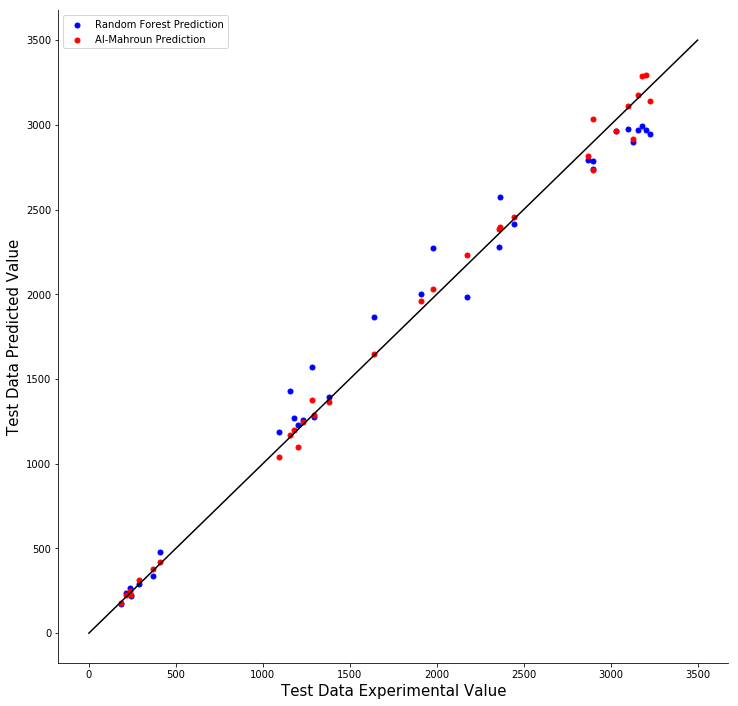

In [207]:
# Plot the predicted values vs the actual values of bubblepoint pressure

# Calculate Al-Mahroun predictions (also given in his paper) using the above equation
AM_pred_ytest = 5.38088 / 1000 *(X_test['gor'] ** 0.715082) * (X_test['yg'] ** -1.877840) * (X_test['y_0'] ** 3.143700) * ((X_test['T']) ** 1.326570)

fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(y_test, rf_reg_opt_grid.predict(X_test), s=25, c='blue')
plt.scatter(y_test, AM_pred_ytest, s=25,  c='red')
plt.legend(['Random Forest Prediction', 'Al-Mahroun Prediction'])
plt.plot([0,3500], [0,3500], '-', c='black')
plt.xlabel("Test Data Experimental Value", fontsize=15)
plt.ylabel("Test Data Predicted Value", fontsize=15)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.savefig('1a_fitted_vs_actual', bbox_inches='tight')

plt.show()

A further 5 datapoints were sourced from the Reservoir Engineering Handbook, 4th Ed [3]. While it has very few datapoints, it's worth taking a look at how Al-Mahroun's and the random forest models predict the bubblepoint pressure for a new dataset. It is not stated in the textbook the source of the measurements. 

Importing the data and cleaning as with the initial data:

In [208]:
df_ahmed = pd.read_csv(ahmed_data_path, index_col='sample')
df_ahmed = df_ahmed.iloc[:5, :]

In [209]:
df_ahmed.head(10)

,bp_p,gor,yg,y_api,Tf
sample,,,,,
1.00,"2,377",751.00,0.85,47.10,250.00
2.00,2620,768.00,0.85,40.70,220.00
3.00,2051,693.00,0.91,48.60,260.00
4.00,"2,884",968.00,0.90,40.50,237.00
5.00,3065,943.00,0.78,44.20,218.00


In [210]:
# Remove commas from bp_p and convert to integers
df_ahmed['bp_p'] = df_ahmed['bp_p'].str.replace(',', '').astype(int) + 14.7 #psig to psia

# Convert y_api to y_0 (oil relative density (water = 1))
df_ahmed['y_api'] = 141.5 / (df_ahmed['y_api'] + 131.5)

# Convert Tf to T (Rankin scale)
df_ahmed['Tf'] = df_ahmed['Tf'] + 459.67

# Rename columns
df_ahmed.columns = ['bp_p', 'gor', 'yg', 'y_0', 'T']

In [211]:
df_ahmed.head(10)

,bp_p,gor,yg,y_0,T
sample,,,,,
1.00,2391.70,751.00,0.85,0.79,709.67
2.00,2634.70,768.00,0.85,0.82,679.67
3.00,2065.70,693.00,0.91,0.79,719.67
4.00,2898.70,968.00,0.90,0.82,696.67
5.00,3079.70,943.00,0.78,0.81,677.67


In [112]:
# Calculate Al-Mahroun predictions for the ahmed dataset

AM_pred_ahmed = 5.38088 / 1000 *(df_ahmed['gor'] ** 0.715082) * (df_ahmed['yg'] ** -1.877840) * (df_ahmed['y_0'] ** 3.143700) * (df_ahmed['T'] ** 1.326570)

In [113]:
# Mean absolute percentage error for Al-Mahroun's predictions:
mean_absolute_percentage_error(df_ahmed['bp_p'], AM_pred_ahmed)

2.997898368566947

In [212]:
# Mean absolute percentage error for random forest predictions:
mean_absolute_percentage_error(df_ahmed['bp_p'], rf_reg_opt_grid.predict(df_ahmed.drop(['bp_p'], axis=1)))

7.594918413277059

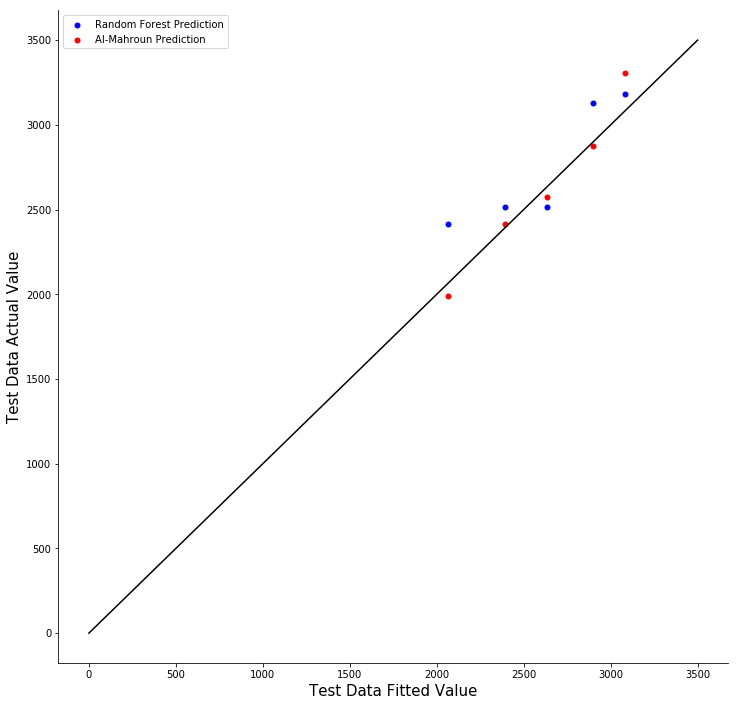

In [213]:
# Plot the predicted values vs the actual values of bubblepoint pressure

fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(df_ahmed['bp_p'], rf_reg_opt_grid.predict(df_ahmed.drop(['bp_p'], axis=1)), s=25, c='blue')
plt.scatter(df_ahmed['bp_p'], AM_pred_ahmed, s=25,  c='red')
plt.legend(['Random Forest Prediction', 'Al-Mahroun Prediction'])
plt.plot([0,3500], [0,3500], '-', c='black')
plt.xlabel("Test Data Fitted Value", fontsize=15)
plt.ylabel("Test Data Actual Value", fontsize=15)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.savefig('1a_fitted_vs_actual', bbox_inches='tight')

plt.show()

## Conclusions:

- Random Forest Regression allows for prediction of bubblepoint pressure using 3 commonly available field data attributes with a mean absolute percentage error of 7.56%. This error is ~2x the mean absolute percentage error achieved by Al-Mahroun, however it is calculated out-of-sample, showing that the model has the ability to generalize. 


- Further predictions on a new dataset of 5 samples showed that the random forest model predicted bubblepoint pressure with a mean absolute percentage error of 7.59%, further indicating the model generalizes well. Al-Mahroun's formula predicted with similar accuracy as for the initial data, indicating that his model can generalize as well.


- The total datapoints analyzed is very small, so these results should be considered with caution.


- This model is valid only for predicting bubblepoint pressures with PVT properties in the range of the data used to fit the model (i.e., the raw dataset).


- A quick and simple implementation of a random forest regression has yielded promising results. Further work on this project could be comparing these results to that of an artificial neural network. Having more available data to work with would allow for greater confidence in model assessment. 